In [1]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from datetime import datetime
import os
from os import path
from tempfile import TemporaryFile
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
from torch.autograd import Variable
import pycuda
from pycuda import compiler
import pycuda.driver as drv
from Datasets import Noisy_MNIST_Dataset, Tangled_MNIST_Dataset
from Plotting import plot_embeddings_single, plot_embeddings_private, display_reconstructions, save_disentangling_curves_single, save_disentangling_curves_private, grid_plot2d_single, grid_plot2d_private, plot_3d_embeddings, display_generated_images
from Nets import VCCA_Single, VCCA_Private
from Model_Training import train_beta_vcca_single, train_abc_vcca_private
from sklearn.svm import LinearSVC, LinearSVR
from sklearn.datasets import make_classification
import json
from sklearn.neighbors import KernelDensity
from scipy.stats import multivariate_normal
import matplotlib.gridspec as gridspec

In [2]:
num_epochs = 2

## Helper Functions

In [3]:
def train_private(z_dim, beta, hx_dim, alpha, hy_dim, gamma, train_loader, validation_loader, test_loader, num_epochs, device, dropout_prob=0.0):
    """
    returns (best_result, best_epoch, best_state_dict, results_dict, last_state_dict, best_acc_state_dict, state_dict_list)
    """
    # Network
    vcca_private = VCCA_Private(z_dim=z_dim, num_z_inputs=num_z, hx_dim=hx_dim, hy_dim=hy_dim, dropout_prob=dropout_prob)

    if torch.cuda.device_count() > 1:
        vcca_private = nn.DataParallel(vcca_private)

    # Train Model - returns (best_result, best_epoch, best_state_dict, results_dict, last_state_dict, best_acc_state_dict, state_dict_list)
    private_results = train_abc_vcca_private(vcca_private.to(device), z_dim, beta, hx_dim, alpha, hy_dim, gamma, train_loader, validation_loader, test_loader, num_epochs, device, True)
    del vcca_private
    
    return private_results

In [11]:
def plot_private_results(z_dim, num_z, hx_dim, hy_dim, alpha, beta, gamma, training_results, test_loader, dropout_prob=0.0):
    """ Generate/Save Plots
        1. 3 embedding plots - with class, rota, and rotb coloring
        2. reconstructions
        3. training curves - 3 losses, class, rota, rotb
    """
    # Load best model
    vcca_private = VCCA_Private(z_dim=z_dim, num_z_inputs=num_z, hx_dim=hx_dim, hy_dim=hy_dim, dropout_prob=dropout_prob)

    if torch.cuda.device_count() > 1:
        vcca_private = nn.DataParallel(vcca_private)
    vcca_private.to(device)    
    vcca_private.load_state_dict(training_results[2])
    vcca_private.eval()
    results = training_results[3]

    # Get out-of-sample (test) data
    x, y, rot_x, rot_y, labels = next(iter(test_loader))

    # Gather embeddings and reconstructions
    x_hat, y_hat, z_mu, z_logvar, hx_mu, hx_logvar, hy_mu, hy_logvar, z, hx, hy = vcca_private(x,y)
    z, hx, hy, labels, rot_x, rot_y, x_hat, y_hat = z_mu.detach().cpu().numpy(), hx_mu.detach().cpu().numpy(), hy_mu.detach().cpu().numpy(), labels.detach().cpu().numpy(), rot_x.detach().cpu().numpy(), rot_y.detach().cpu().numpy(), x_hat.detach().cpu().numpy(), y_hat.detach().cpu().numpy()

    # 1. 3 embedding plots - with class, rota, and rotb coloring
    # test
    plot_embeddings_private(z, hx, hy, labels, results_path + 'vcca_embeddings.png')

    # 2. reconstructions
    display_reconstructions(x, x_hat, y, y_hat, results_path + 'vcca_reconstructions.png')

    # 3. training curves
    save_disentangling_curves_private(results, results_path + 'vcca_training_curves.png')

    # 4. embeddings plots comparing info content
    plot_embeddings_single(z, labels, rot_x, rot_y, results_path + 'vcca_z_embeddings.png')
    plot_embeddings_single(hx, labels, rot_x, rot_y, results_path + 'vcca_hx_embeddings.png')
    plot_embeddings_single(hy, labels, rot_x, rot_y, results_path + 'vcca_hy_embeddings.png')

    # 5. Goodness of Fit
    x_flat = np.linspace(-4, 4, 100)
    y_flat = np.linspace(-4, 4, 100)
    xi, yi = np.meshgrid(x_flat, y_flat)

    # Create a figure with 4 plot areas
    fig = plt.figure(figsize=(14, 14), constrained_layout=True)
    nbins = 100
    grid_data = np.vstack([xi.flatten(), yi.flatten()]).T
    levels = np.arange(-10,0.,0.5)
    spec = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)
    ax0 = fig.add_subplot(spec[0, 0])
    ax1 = fig.add_subplot(spec[0, 1])
    ax2 = fig.add_subplot(spec[1, 0])
    ax3 = fig.add_subplot(spec[1, 1])

    # Gaussian plot
    rv = multivariate_normal([0, 0], [[1, 0.], [0., 1]])
    gaussiani = rv.logpdf(grid_data)
    ax0.set_title('N(0,I) Log Probibility Contours')
    im0 = ax0.pcolormesh(xi, yi, gaussiani.reshape(xi.shape), shading='gouraud', cmap='plasma')
    ax0.contour(xi, yi, gaussiani.reshape(xi.shape), levels=levels)
    ax0.axis('equal')
    ax0.set_aspect('equal', 'box')
    ax0.set(xlim=(-4, 4), ylim=(-4, 4))
    fig.colorbar(im0, ax=ax0)

    # z Plot
    kde_z = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(z)
    z_scores = kde_z.score_samples(grid_data)
    ax1.set_title('z with Beta=' + str(beta))
    im1 = ax1.pcolormesh(xi, yi, z_scores.reshape(xi.shape), shading='gouraud', cmap='plasma')
    ax1.contour(xi, yi, z_scores.reshape(xi.shape), levels=levels)
    ax1.axis('equal')
    ax1.set_aspect('equal', 'box')
    ax1.set(xlim=(-4, 4), ylim=(-4, 4))
    fig.colorbar(im1, ax=ax1)

    # hx Plot
    kde_hx = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(hx)
    hx_scores = kde_hx.score_samples(grid_data)
    ax2.set_title('hx with Alpha=' + str(alpha))
    im2 = ax2.pcolormesh(xi, yi, hx_scores.reshape(xi.shape), shading='gouraud', cmap='plasma')
    ax2.contour(xi, yi, hx_scores.reshape(xi.shape), levels=levels)
    ax2.axis('equal')
    ax2.set_aspect('equal', 'box')
    ax2.set(xlim=(-4, 4), ylim=(-4, 4))
    fig.colorbar(im2, ax=ax2)

    # hy Plot
    kde_hy = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(hy)
    hy_scores = kde_hy.score_samples(grid_data)
    ax3.set_title('hy with Gamma=' + str(gamma))
    im3 = ax3.pcolormesh(xi, yi, hy_scores.reshape(xi.shape), shading='gouraud', cmap='plasma')
    ax3.contour(xi, yi, hy_scores.reshape(xi.shape), levels=levels)
    ax3.axis('equal')
    ax3.set_aspect('equal', 'box')
    ax3.set(xlim=(-4, 4), ylim=(-4, 4))
    fig.colorbar(im3, ax=ax3)

#     fig.tight_layout()
    fig.suptitle('ABC-VCCA-Private Embeddings on Out of Sample Data', fontsize=16)
#     fig.subplots_adjust(wspace=0.75, hspace=0.75)

In [5]:
def train_single(z_dim, beta, train_loader, validation_loader, test_loader, num_epochs, device, dropout_prob=0.0):
    # Network
    vcca_single = VCCA_Single(z_dim=z_dim, num_z=num_z, dropout_prob=dropout_prob)
    if torch.cuda.device_count() > 1:
        vcca_single = nn.DataParallel(vcca_single)

    # Train Model - returns (best_result, best_epoch, best_state_dict, results_dict, last_state_dict, best_acc_state_dict, state_dict_list)
    single_results = train_beta_vcca_single(vcca_single.to(device), z_dim, beta, train_loader, validation_loader, test_loader, num_epochs, device, True)
    del vcca_single
    return single_results

In [6]:
def plot_single_results(z_dim, num_z, test_loader, training_results, dropout_prob=0.0):
    """ Generate/Save Plots
        1. 3 embedding plots - with class, rota, and rotb coloring
        2. reconstructions
        3. training curves - 3 losses, class, rota, rotb
        4. random generations over (-3,3)x(-3,3)
    """
    # Load best model
    vcca_single = VCCA_Single(z_dim=z_dim, num_z=num_z, dropout_prob=dropout_prob)
    if torch.cuda.device_count() > 1:
        vcca_single = nn.DataParallel(vcca_single)
    vcca_single.to(device)
    vcca_single.load_state_dict(training_results[2])
    vcca_single.eval()
    results = training_results[3]

    # Get out-of-sample (test) data
    x, y, rot_x, rot_y, labels = next(iter(test_loader))

    # Gather embeddings and reconstructions
    x_hat, y_hat, z_mu, z_logvar, z = vcca_single(x.to(device),y.to(device))
    z_vcca, labels_vcca, rot_x_vcca, rot_y_vcca, x_hat_vcca, y_hat_vcca = z_mu.detach().cpu().numpy(), labels.detach().cpu().numpy(), rot_x.detach().cpu().numpy(), rot_y.detach().cpu().numpy(), x_hat.detach().cpu().numpy(), y_hat.detach().cpu().numpy()

    # 1. 3 embedding plots - with class, rota, and rotb coloring
    # test
    plot_embeddings_single(z_vcca,labels_vcca,rot_x_vcca,rot_y_vcca,results_path + 'vcca_embeddings.png')

    # 2. reconstructions
    display_reconstructions(x, x_hat_vcca, y, y_hat_vcca, results_path + 'vcca_reconstructions.png')

    # 3. training curves
    save_disentangling_curves_single(results, results_path + 'vcca_training_curves.png')

    # 4. random generations over (-2.5,2.5)x(-2.5,2.5)
    grid_plot2d_single(vcca_single, results_path + 'vcca_x_generations.png', output_view_name='x')
    grid_plot2d_single(vcca_single, results_path + 'vcca_y_generations.png', output_view_name='y')
    
    return z_vcca

# Experiments

## Beta-VCCA

### Experiment 1: Varying Beta with z_dim=2 on Tangled MNIST

In [13]:
"""
Experiment 1.1 VCCA_Single on Tangled MNIST
Model params:
    No dropout
    z_dim = 2
    q(z|x,y) not just q(z|x)
Plots:
    3 embedding plots - with class, rota, and rotb coloring
    reconstructions
    training curves - 3 losses, class, rota, rotb
    random generations over (-3,3)x(-3,3)
    want to demonstrate goodness of fit argument
"""
torch.cuda.empty_cache() 

# For reproducibility
torch.manual_seed(10)

# General Parameters
MNIST_type = 'MNIST' # choose from {'MNIST', 'FashionMNIST', 'KMNIST'}
batch_size = 500
cuda = True # change to False if not using GPUs
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
device = "cuda:0"

# Experiment Paramaters
# num_epochs = 100
num_z = 2 # 2 indicates encoder is q(z|x,y), 1 indicates encoder is q(z|x) - though with 1, there is no hope of view-specific info from y making it into z, only view-specific info from x
z_dim = 2
dropout_prob = 0.0
best_results = {}
results_path = './results/1/1/'
if not os.path.exists(results_path):  # checking on results directory
    os.makedirs(results_path)

# Create Dataset
train_dataset = Tangled_MNIST_Dataset(mnist_type=MNIST_type, train=True)
test_dataset = Tangled_MNIST_Dataset(mnist_type=MNIST_type, train=False)

train_loader = torch.utils.data.DataLoader( 
    train_dataset,
    batch_size=batch_size, shuffle=True, **kwargs)
validation_loader = torch.utils.data.DataLoader( 
    train_dataset,
    batch_size=50000, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=10000, shuffle=True, **kwargs)

betas = [0.1, 1.0, 10.0]

new best loss 220339.938671875  epoch 0
new best loss 196540.66458333333  epoch 1


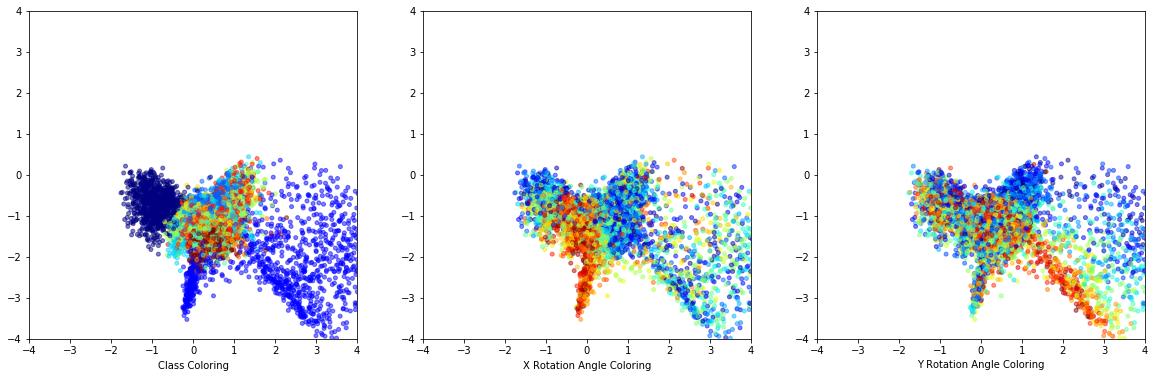

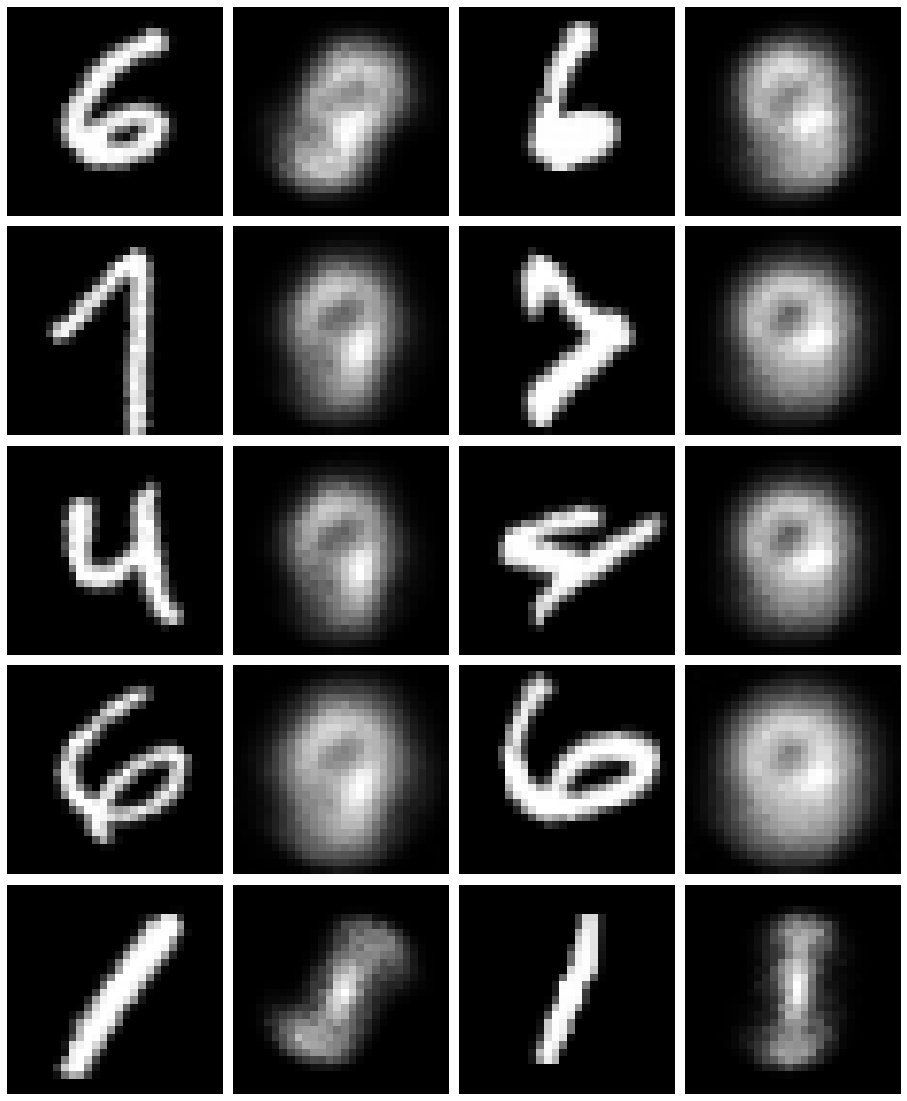

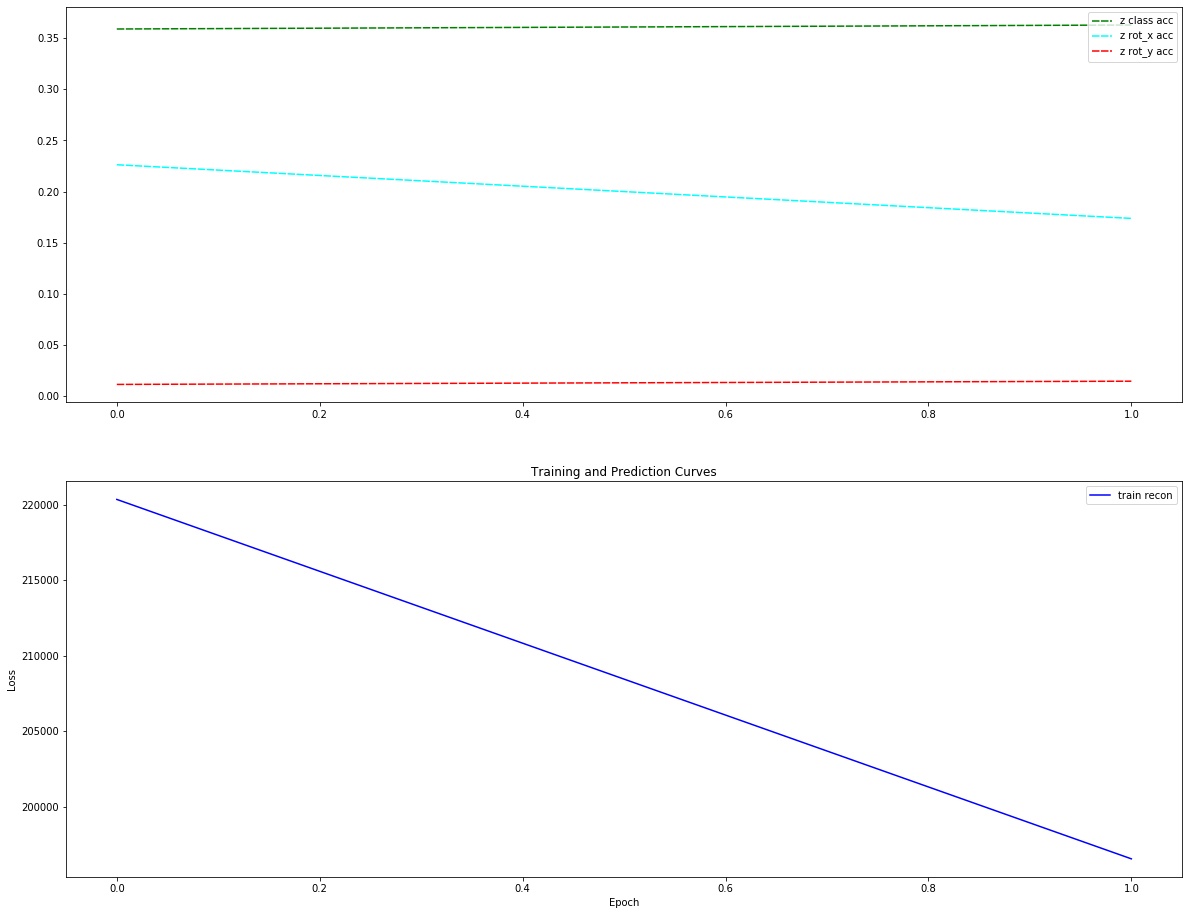

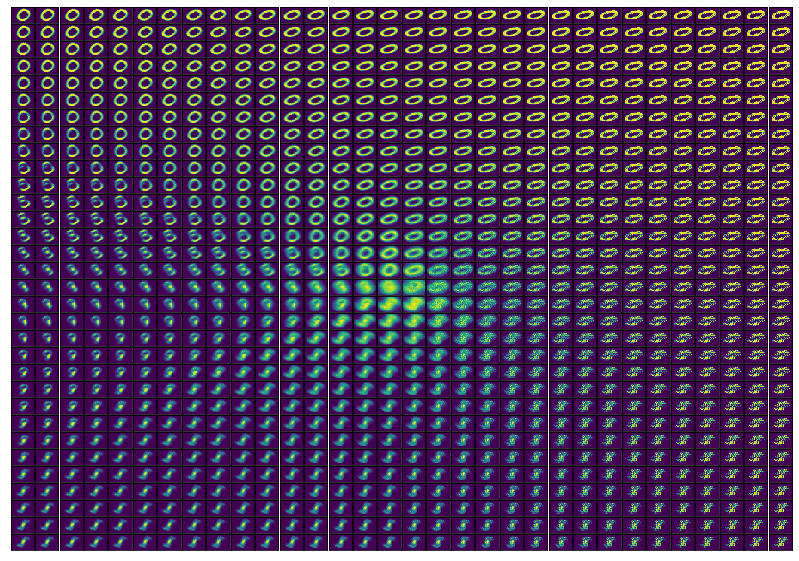

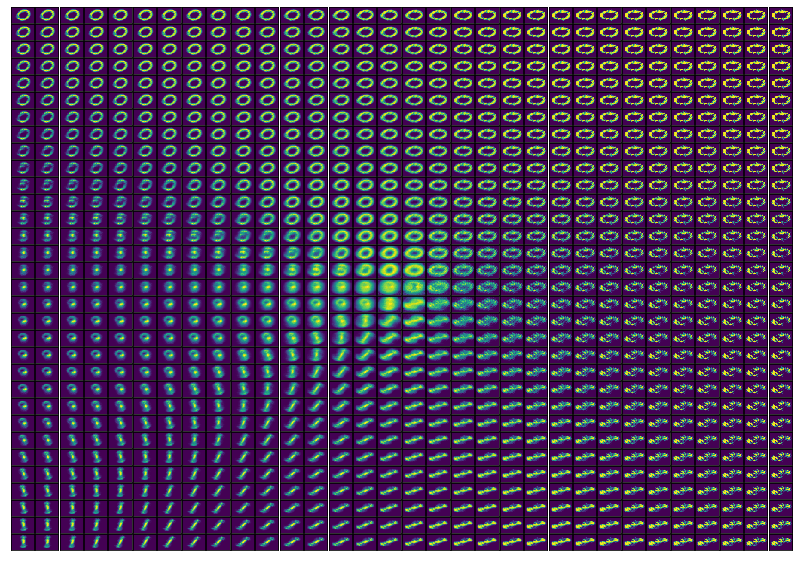

In [14]:
beta = betas[0]
training_results_01 = train_single(z_dim, beta, train_loader, validation_loader, test_loader, num_epochs, device, dropout_prob=0.0)
z_01 = plot_single_results(z_dim, num_z, test_loader, training_results_01, dropout_prob=0.0)

new best loss 220051.09661458334  epoch 0
new best loss 199331.31328125  epoch 1


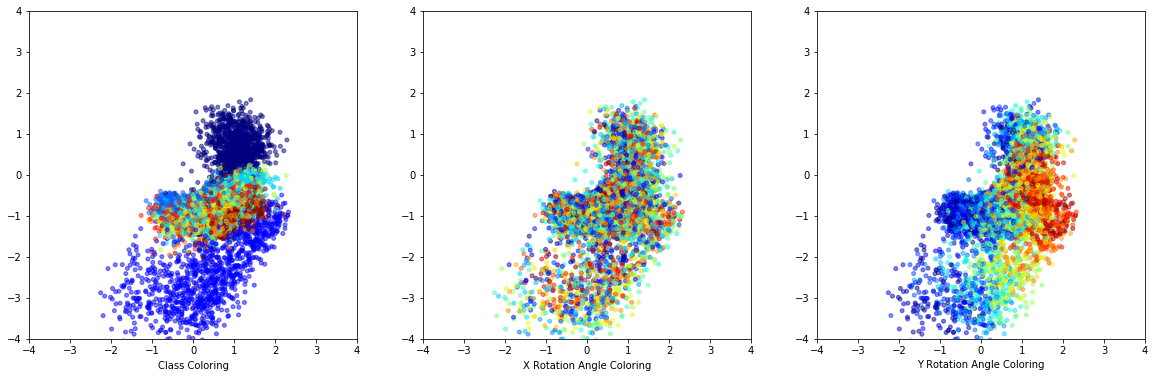

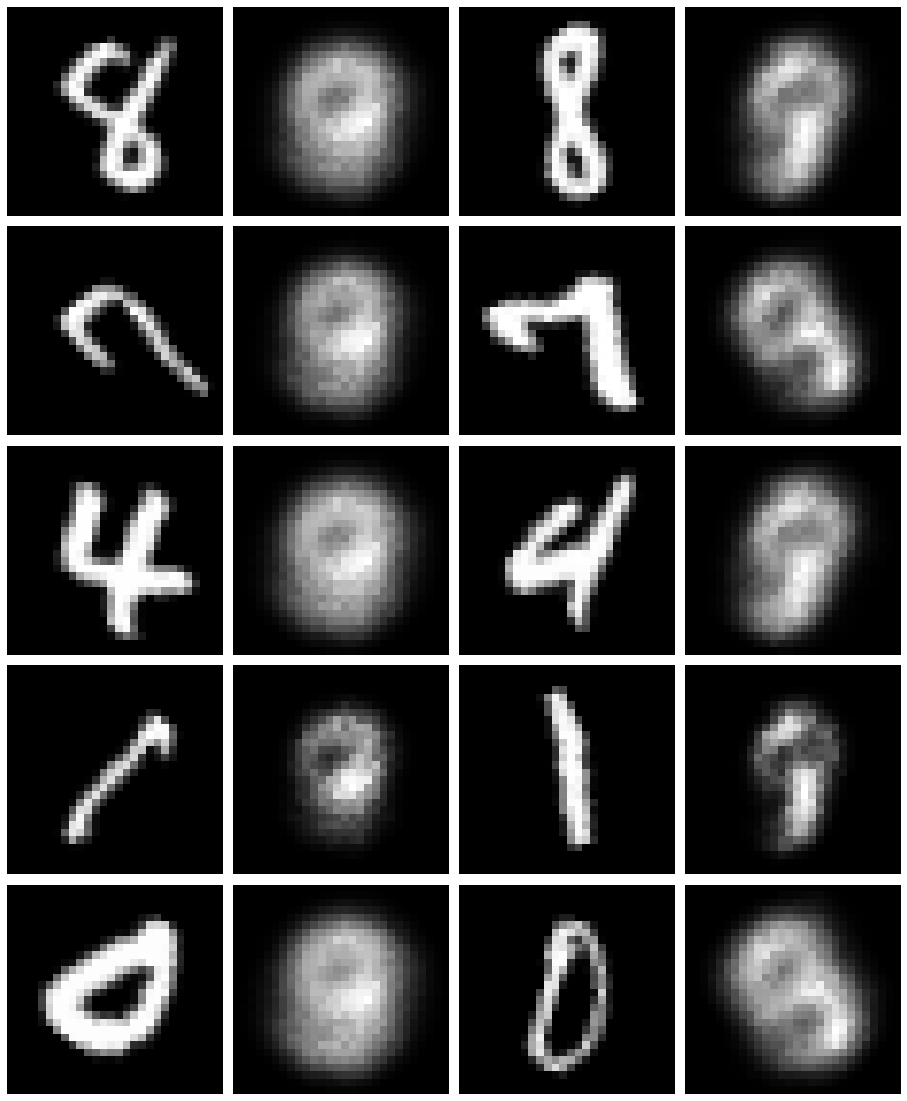

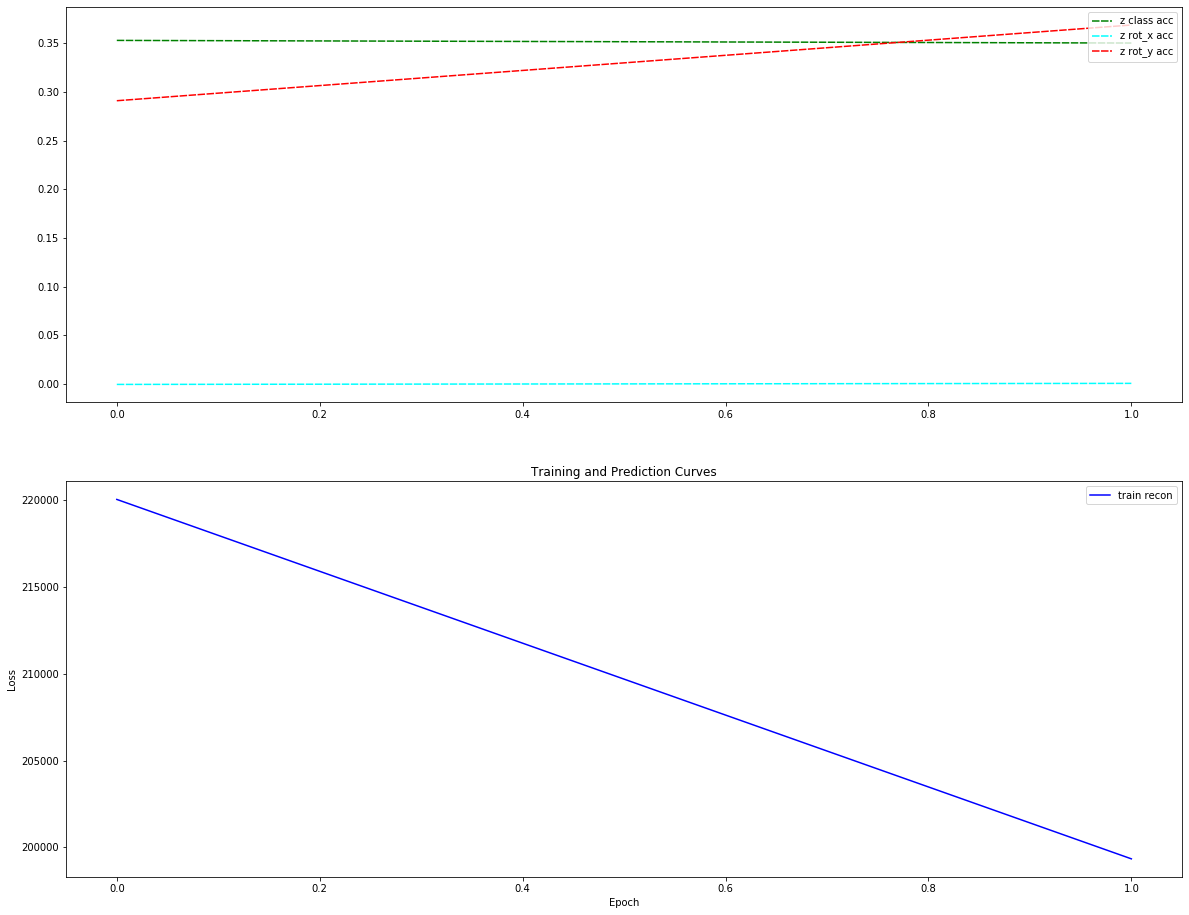

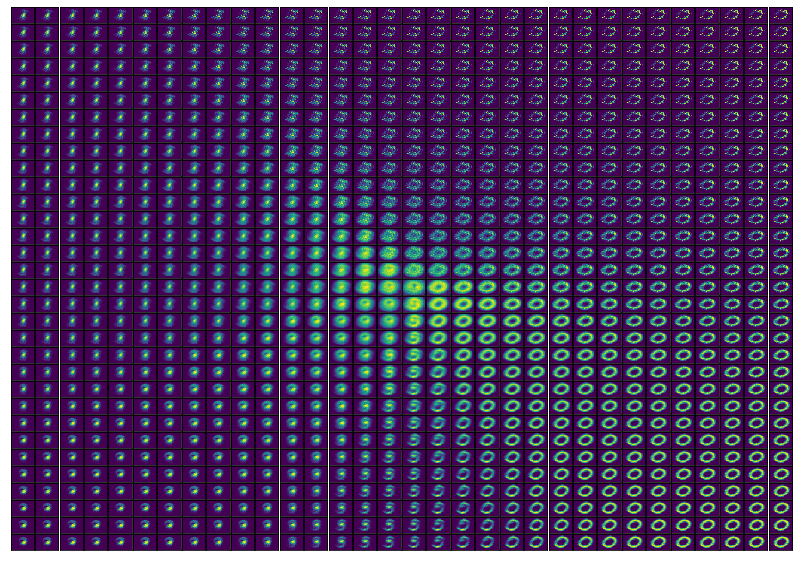

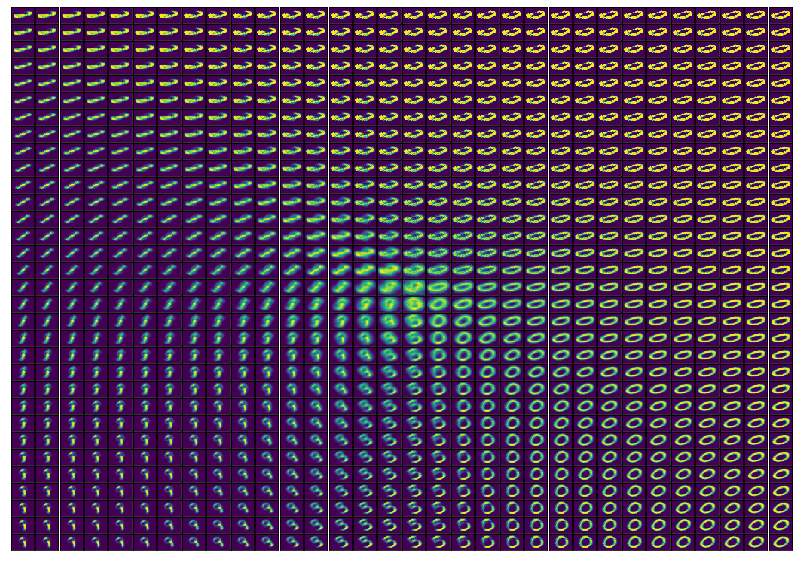

In [15]:
beta = betas[1]
training_results_1 = train_single(z_dim, beta, train_loader, validation_loader, test_loader, num_epochs, device, dropout_prob=0.0)
z_1 = plot_single_results(z_dim, num_z, test_loader, training_results_1, dropout_prob=0.0)

new best loss 239256.19375  epoch 0
new best loss 213995.60625  epoch 1


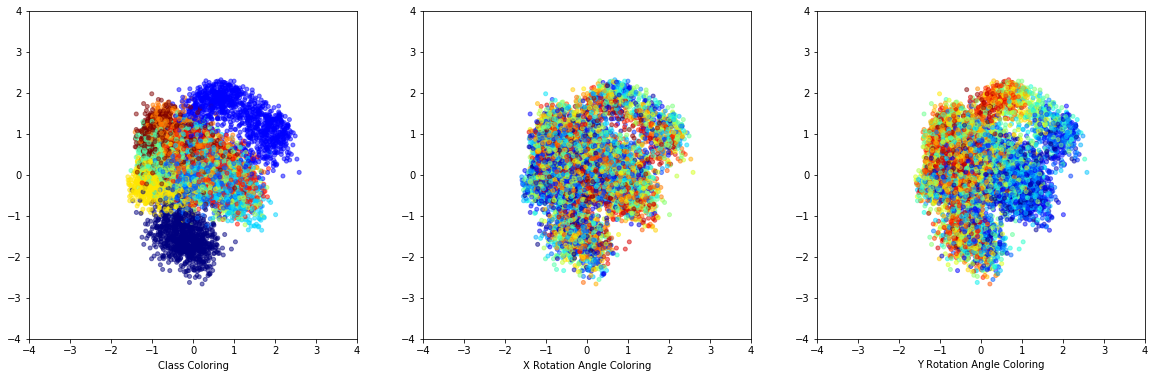

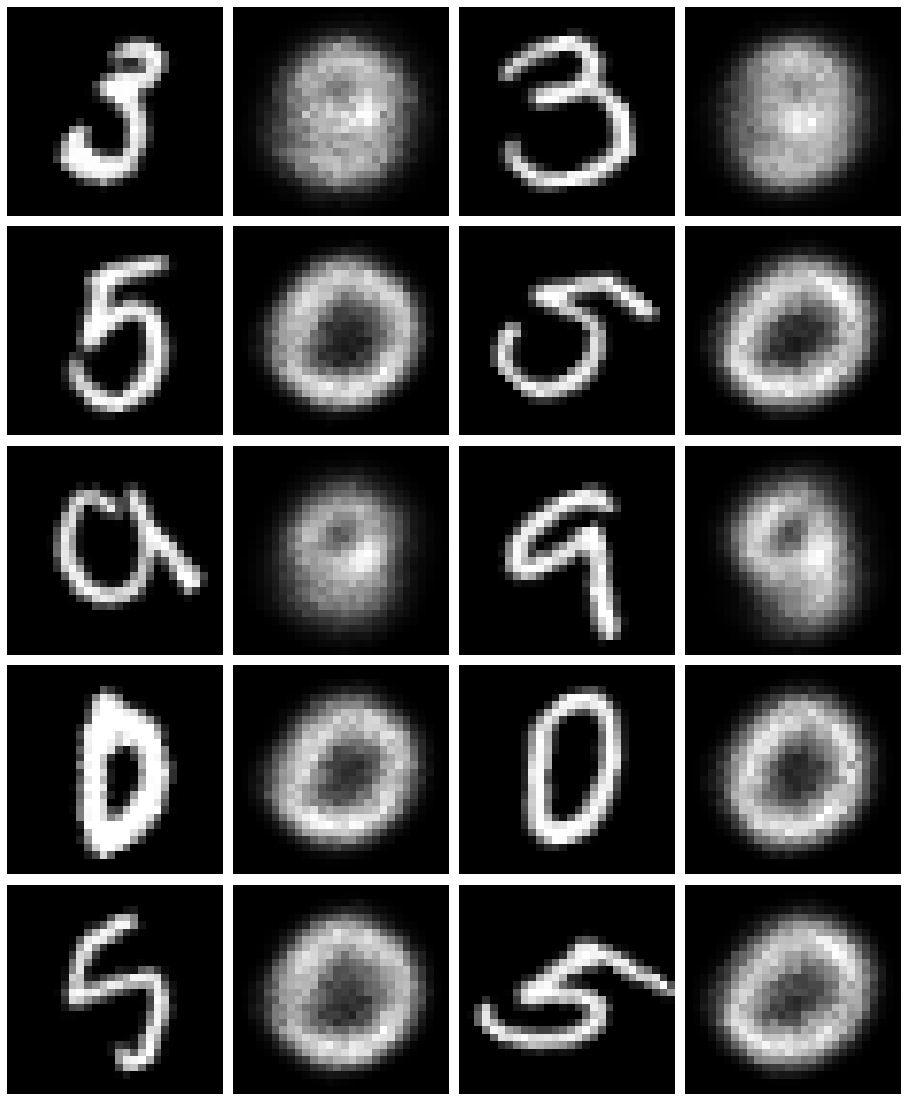

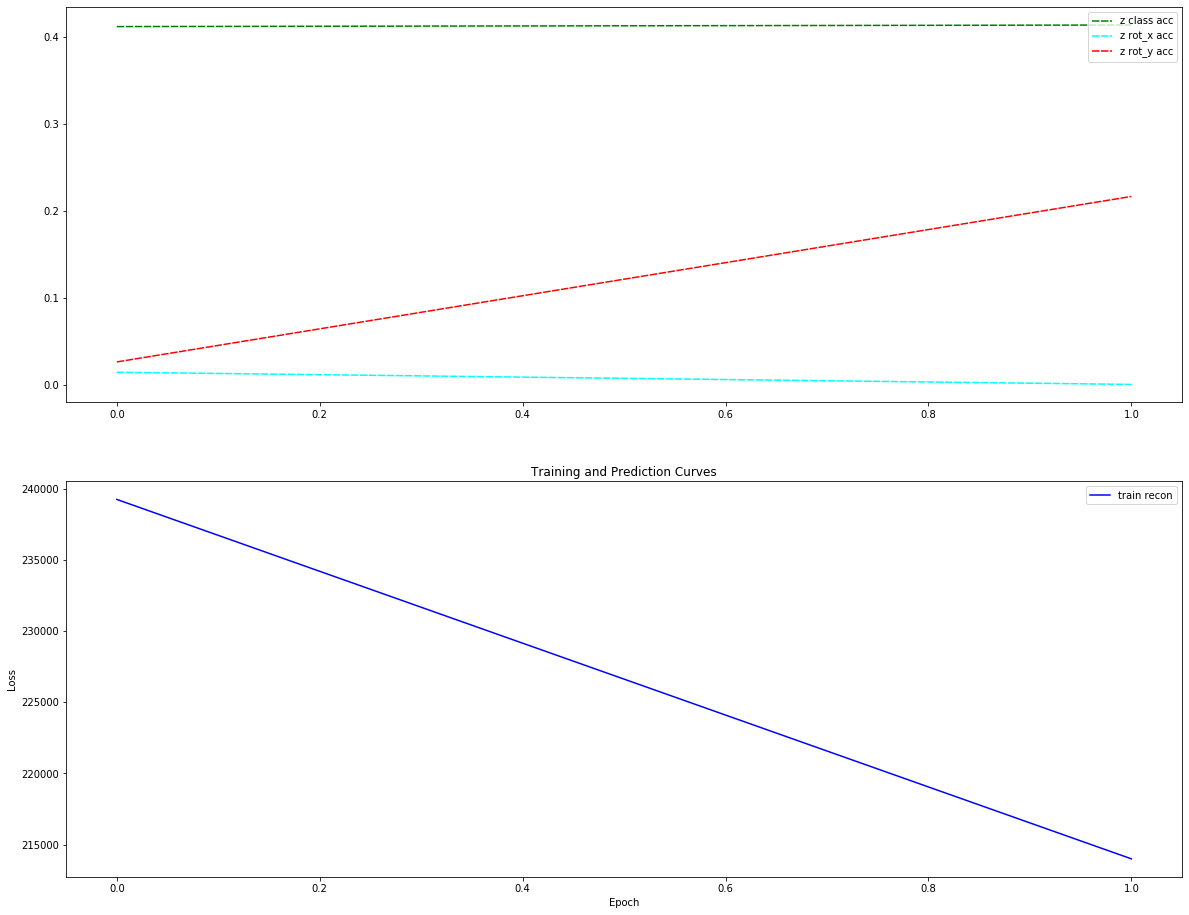

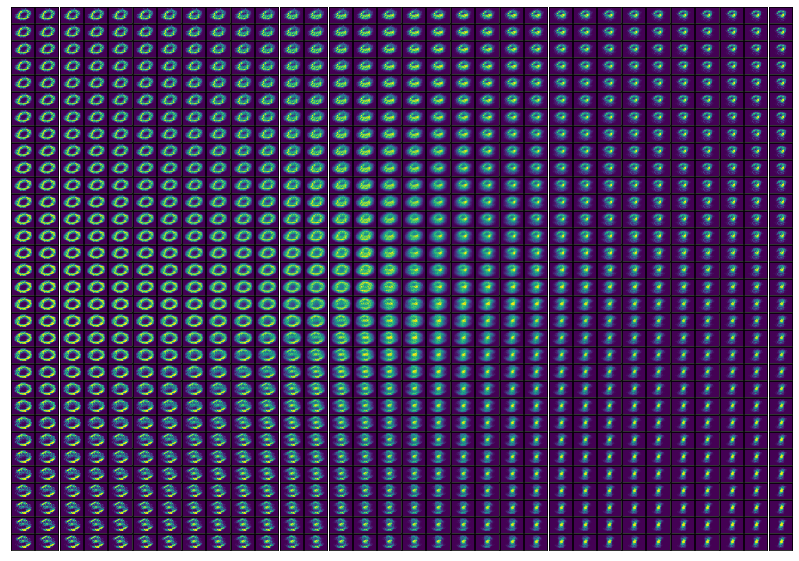

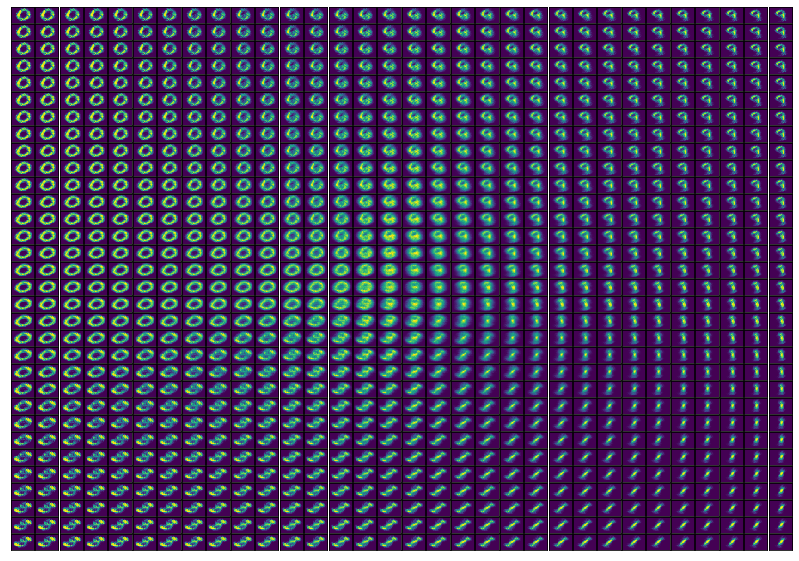

In [16]:
beta = betas[2]
training_results_10 = train_single(z_dim, beta, train_loader, validation_loader, test_loader, num_epochs, device, dropout_prob=0.0)
z_10 = plot_single_results(z_dim, num_z, test_loader, training_results_10, dropout_prob=0.0)

### Experiment 1 Goodness of Fit Analysis

Text(0.5, 0.98, 'Beta-VCCA Embeddings of z on Out of Sample Data')

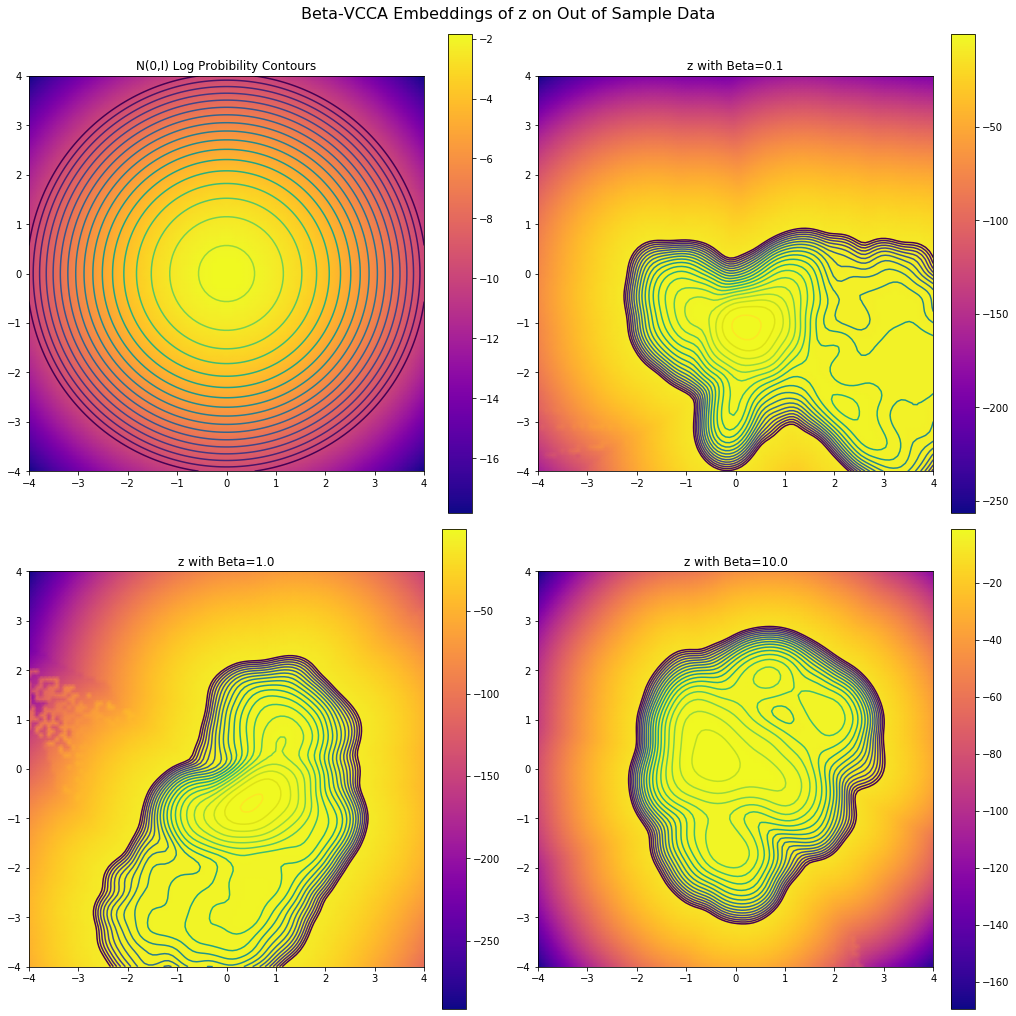

In [17]:
x_flat = np.linspace(-4, 4, 100)
y_flat = np.linspace(-4, 4, 100)
xi, yi = np.meshgrid(x_flat, y_flat)

# Create a figure with 4 plot areas
fig = plt.figure(figsize=(14, 14), constrained_layout=True)
nbins = 100
grid_data = np.vstack([xi.flatten(), yi.flatten()]).T
levels = np.arange(-10,0.,0.5)
spec = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)
ax0 = fig.add_subplot(spec[0, 0])
ax1 = fig.add_subplot(spec[0, 1])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[1, 1])

# Gaussian plot
rv = multivariate_normal([0, 0], [[1, 0.], [0., 1]])
gaussiani = rv.logpdf(grid_data)
ax0.set_title('N(0,I) Log Probibility Contours')
im0 = ax0.pcolormesh(xi, yi, gaussiani.reshape(xi.shape), shading='gouraud', cmap='plasma')
ax0.contour(xi, yi, gaussiani.reshape(xi.shape), levels=levels)
ax0.axis('equal')
ax0.set_aspect('equal', 'box')
ax0.set(xlim=(-4, 4), ylim=(-4, 4))
fig.colorbar(im0, ax=ax0)

# Beta-VCCA Plot, Beta = 0.1
kde_vcca_01 = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(z_01)
zi_vcca_01 = kde_vcca_01.score_samples(grid_data)
ax1.set_title('z with Beta=' + str(betas[0]))
im1 = ax1.pcolormesh(xi, yi, zi_vcca_01.reshape(xi.shape), shading='gouraud', cmap='plasma')
ax1.contour(xi, yi, zi_vcca_01.reshape(xi.shape), levels=levels)
ax1.axis('equal')
ax1.set_aspect('equal', 'box')
ax1.set(xlim=(-4, 4), ylim=(-4, 4))
fig.colorbar(im1, ax=ax1)

# Beta-VCCA Plot, Beta = 1.0
kde_vcca_1 = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(z_1)
zi_vcca_1 = kde_vcca_1.score_samples(grid_data)
ax2.set_title('z with Beta=' + str(betas[1]))
im2 = ax2.pcolormesh(xi, yi, zi_vcca_1.reshape(xi.shape), shading='gouraud', cmap='plasma')
ax2.contour(xi, yi, zi_vcca_1.reshape(xi.shape), levels=levels)
ax2.axis('equal')
ax2.set_aspect('equal', 'box')
ax2.set(xlim=(-4, 4), ylim=(-4, 4))
fig.colorbar(im2, ax=ax2)

# Beta-VCCA Plot, Beta = 10.0
kde_vcca_10 = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(z_10)
zi_vcca_10 = kde_vcca_10.score_samples(grid_data)
ax3.set_title('z with Beta=' + str(betas[2]))
im3 = ax3.pcolormesh(xi, yi, zi_vcca_10.reshape(xi.shape), shading='gouraud', cmap='plasma')
ax3.contour(xi, yi, zi_vcca_10.reshape(xi.shape), levels=levels)
ax3.axis('equal')
ax3.set_aspect('equal', 'box')
ax3.set(xlim=(-4, 4), ylim=(-4, 4))
fig.colorbar(im3, ax=ax3)

fig.suptitle('Beta-VCCA Embeddings of z on Out of Sample Data', fontsize=16)

# Alpha, Beta, Gamma VCCA-Private

### Experiment 2: Varying Alpha, Beta, Gamma with dim=2 on each on Tangled MNIST

In [7]:
"""
Experiment 2.1 VCCA_Private on Tangled MNIST
Model params:
    No dropout
    z_dim = 2
    hx_dim = 2
    hy_dim = 2
    q(z|x,y) not just q(z|x)
Plots:
    3 embedding plots - with class, rota, and rotb coloring
    reconstructions
    training curves - 3 losses, class, rota, rotb
    want to demonstrate goodness of fit argument
"""

# For reproducibility
torch.manual_seed(10)

# General Parameters
MNIST_type = 'MNIST' # choose from {'MNIST', 'FashionMNIST', 'KMNIST'}
batch_size = 300
cuda = True # change to False if not using GPUs
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
device = "cuda:0"

# Experiment Paramaters
# num_epochs = 100
num_z = 1 # 2 indicates encoder is q(z|x,y), 1 indicates encoder is q(z|x) - though with 1, there is no hope of view-specific info from y making it into z, only view-specific info from x
z_dim = 2
hx_dim = 2
hy_dim = 2
dropout_prob = 0.0
best_results = {}
results_path = './results/2/1/'
if not os.path.exists(results_path):  # checking on results directory
    os.makedirs(results_path)

# Create Dataset
train_dataset = Tangled_MNIST_Dataset(mnist_type=MNIST_type, train=True)
test_dataset = Tangled_MNIST_Dataset(mnist_type=MNIST_type, train=False)

train_loader = torch.utils.data.DataLoader( 
    train_dataset,
    batch_size=batch_size, shuffle=True, **kwargs)
validation_loader = torch.utils.data.DataLoader(# not using out-of-sample validation - using training data.  This is used to evaluate information content of representation
    train_dataset,
    batch_size=50000, shuffle=False, **kwargs)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=10000, shuffle=True, **kwargs)

In [8]:
alpha, beta, gamma = 0.1, 0.1, 0.1
training_results_01 = train_private(z_dim, beta, hx_dim, alpha, hy_dim, gamma, train_loader, validation_loader, test_loader, num_epochs, device, dropout_prob=0.0)

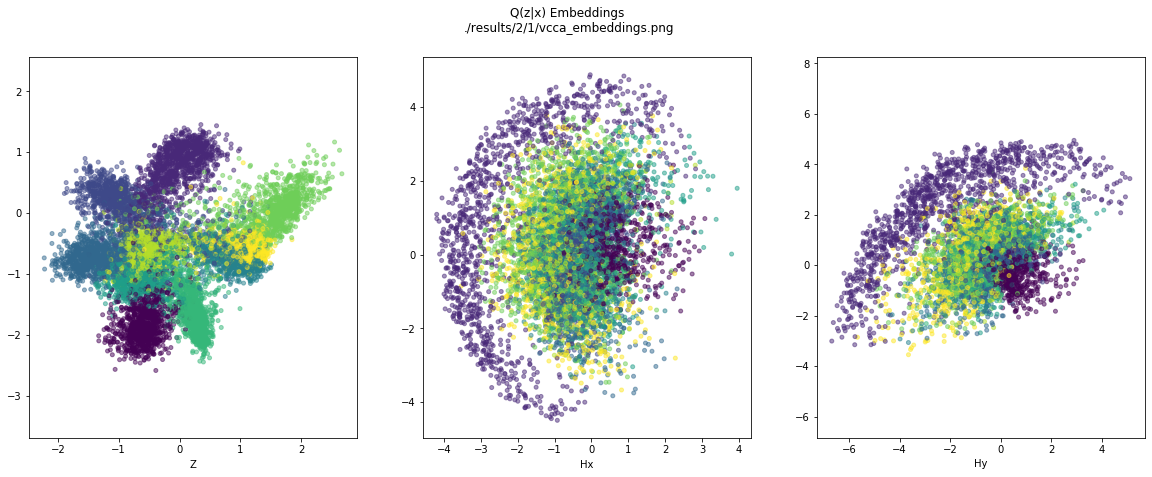

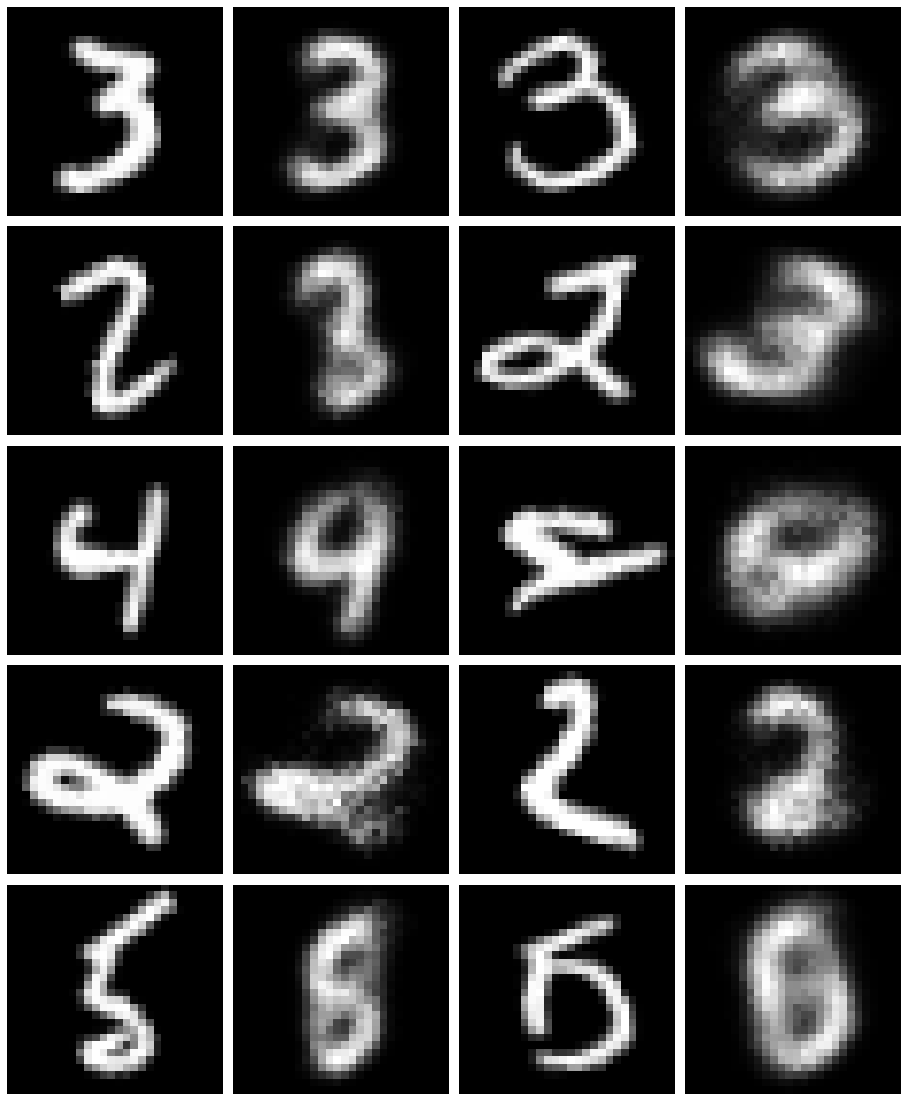

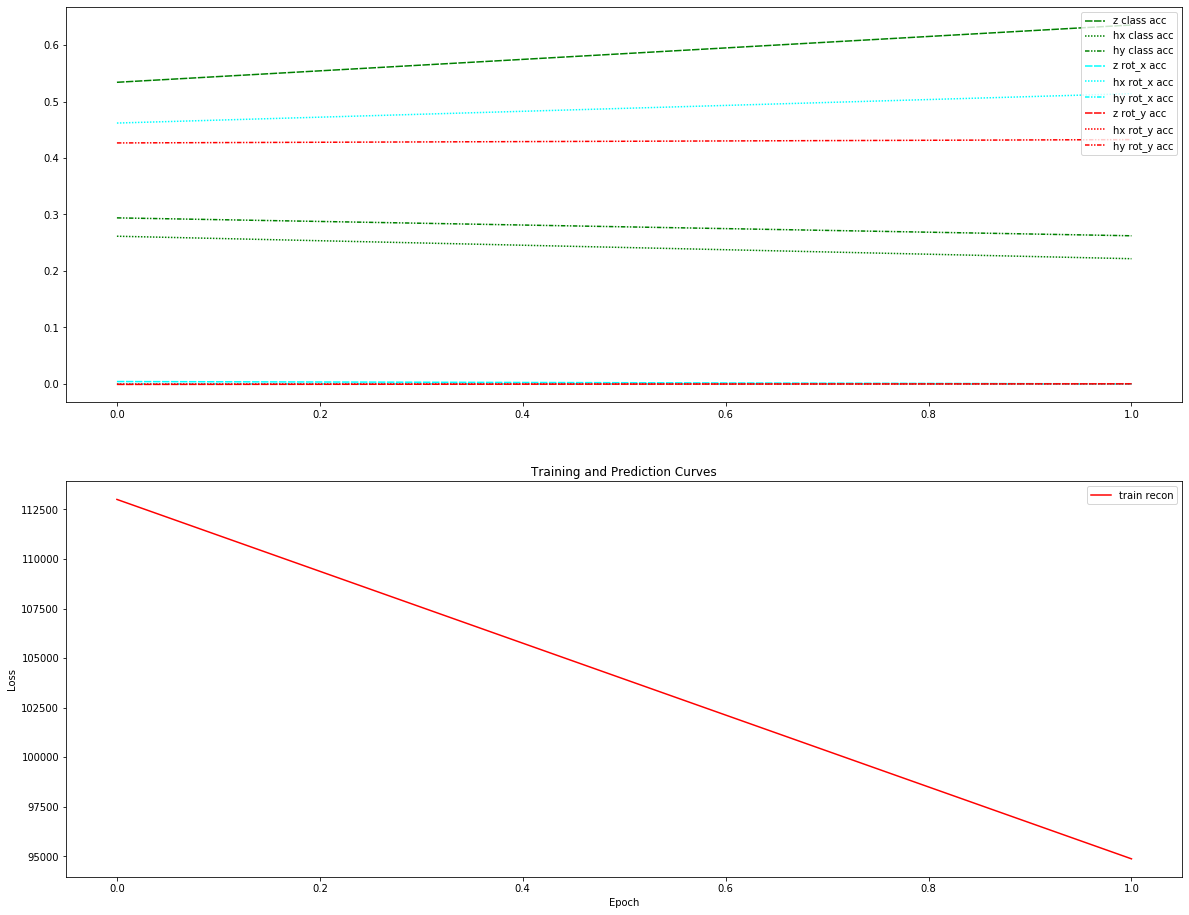

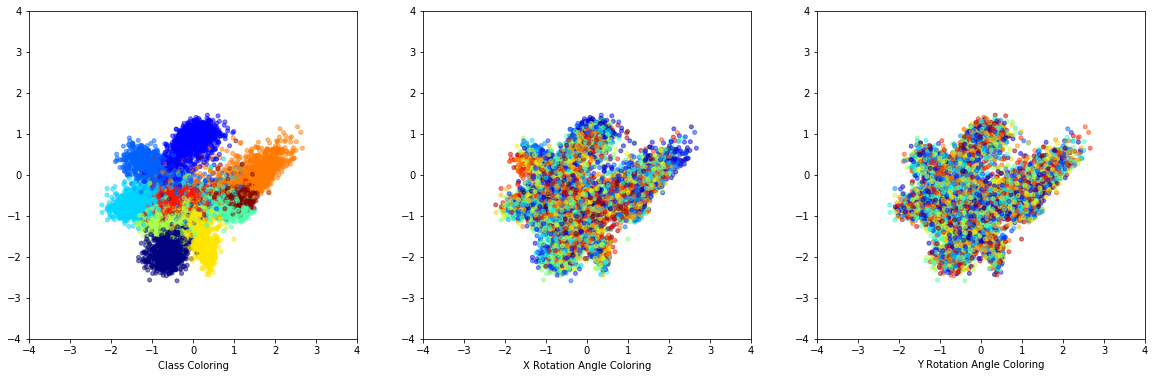

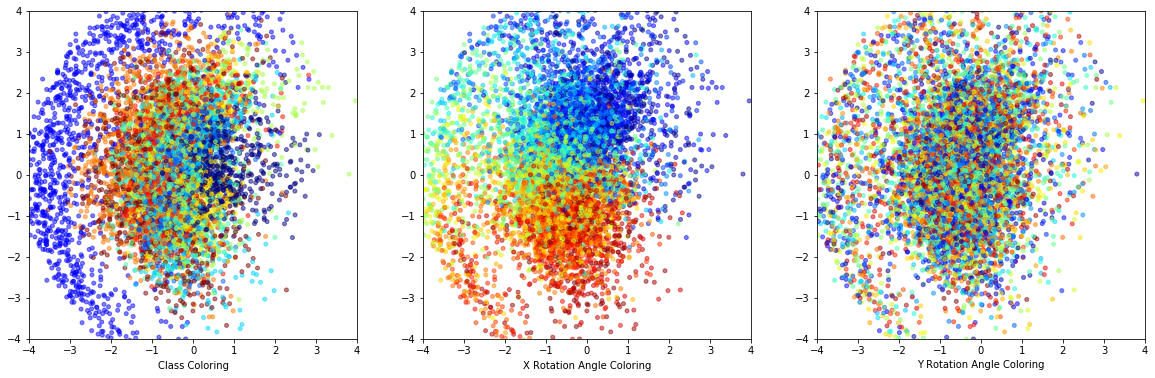

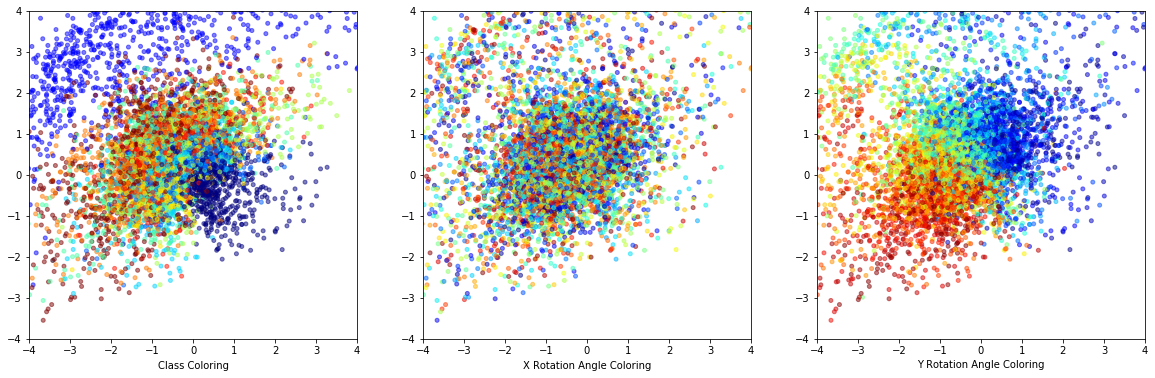

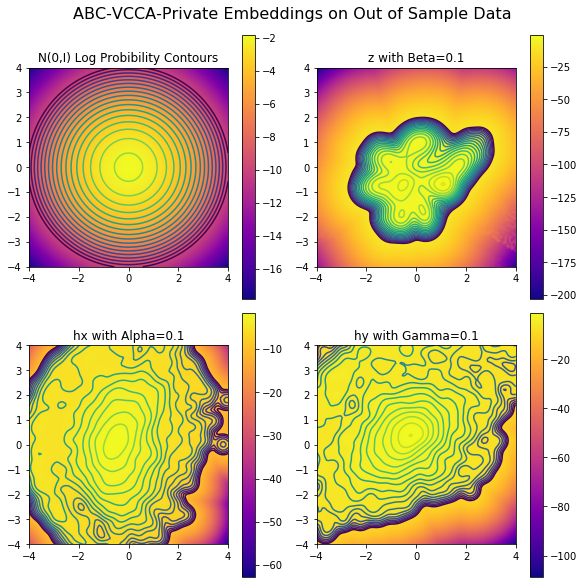

In [12]:
plot_private_results(z_dim, num_z, hx_dim, hy_dim, alpha, beta, gamma, training_results_01, test_loader, dropout_prob=0.0)

In [ ]:
alpha, beta, gamma = 1.0, 1.0, 1.0
training_results_1 = train_private(z_dim, beta, hx_dim, alpha, hy_dim, gamma, train_loader, validation_loader, test_loader, num_epochs, device, dropout_prob=0.0)
plot_private_results(z_dim, num_z, hx_dim, hy_dim, alpha, beta, gamma, training_results_1, test_loader, dropout_prob=0.0)

In [ ]:
alpha, beta, gamma = 5., 5., 5.
training_results_5 = train_private(z_dim, beta, hx_dim, alpha, hy_dim, gamma, train_loader, validation_loader, test_loader, num_epochs, device, dropout_prob=0.0)
plot_private_results(z_dim, num_z, hx_dim, hy_dim, alpha, beta, gamma, training_results_5, test_loader, dropout_prob=0.0)

In [ ]:
alpha, beta, gamma = 10., 10., 10.
training_results_10 = train_private(z_dim, beta, hx_dim, alpha, hy_dim, gamma, train_loader, validation_loader, test_loader, num_epochs, device, dropout_prob=0.0)
plot_private_results(z_dim, num_z, hx_dim, hy_dim, alpha, beta, gamma, training_results_10, test_loader, dropout_prob=0.0)